In [2]:
from eda_import import *

In [3]:
def sizeof_fmt(num, sep=''):
    '''
    :param sep': separate between the number of unit, sometimes it's preferred
    for better readability
    '''
    for unit in ['Bytes', 'KB', 'MB', 'GB', 'TB', 'PB', 'EB', 'ZB']:
        if abs(num) < 1024.0:
            return "%3.1f%s" % (num, unit)
        num /= 1024.0
    return "%.1f%s" % (num, 'YB')

In [4]:
print(datetime.datetime.now().date())

2018-05-08


In [7]:
%time df0 = pd.read_csv('./metadata/LATEST_MANIFEST.final.tsv.gz', low_memory=False, sep='\t', compression='gzip')

CPU times: user 1 s, sys: 24.2 s, total: 25.2 s
Wall time: 35.4 s


In [8]:
%time df1 = pd.read_csv('./metadata/RNAseq_FastQC.csv.gz', compression='gzip')

CPU times: user 919 ms, sys: 2.02 s, total: 2.94 s
Wall time: 6.09 s


In [9]:
%time df2 = pd.read_csv('./metadata/GCS_listing_27apr2016.csv.gz', compression='gzip')

CPU times: user 281 ms, sys: 196 ms, total: 477 ms
Wall time: 618 ms


In [10]:
df2['pretty_size'] = df2.objectSizeBytes.apply(sizeof_fmt)

In [12]:
print(df0.shape)
print(df1.shape)
print(df2.shape)

(128399, 37)
(22408, 174)
(83451, 6)


In [14]:
assert df0.analysis_id.unique().shape[0] == 128189

In [15]:
ndf = df1.merge(df0, left_on='CGHub_analysisID', right_on='analysis_id')

In [16]:
ndf = ndf.merge(df2, left_on=['CGHub_analysisID', 'AliquotBarcode'], right_on=['CGHubAnalysisID', 'AliquotBarcode'])

In [17]:
assert ndf.analysis_id.unique().shape[0] == 11340

In [18]:
assert ndf.shape == (22408, 216)

In [19]:
ndf.columns.values[:20]

array(['CGHub_analysisID', 'AliquotBarcode', 'fastqFilename',
       'FastQC_html_url', 'FastQC_zip_url', 'BasicStats', 'numTotalSeq',
       'numPoorSeq', 'minLength', 'maxLength', 'delLength', 'pctGC',
       'PerBaseSeqQual', 'PBSQ10_0', 'PBSQ50_0', 'PBSQ10_1', 'PBSQ50_1',
       'PBSQ10_2', 'PBSQ50_2', 'PBSQ10_3'], dtype=object)

#### Add some handy columns

In [23]:
ndf['handy_disease_names'] = ndf.apply(lambda x: '{0}: {1}'.format(
        x.disease, ' '.join([_.capitalize() for _ in x.disease_name.split()])), axis=1)

In [26]:
ndf.handy_disease_names.sample(2)

6791     PAAD: Pancreatic Adenocarcinoma
12644    BRCA: Breast Invasive Carcinoma
Name: handy_disease_names, dtype: object

In [27]:
# Drop columns that are not interested at the moment
cols = ndf.columns.values
cols_to_drop = [_ for _ in cols if re.search('^Per|^PBSQ|^PSQC|^PBSC|^PSGCC|^PBNC|^SLD_|^Dedup_|^OverRepSeq|^Kmer_', _)]
ndf.drop(cols_to_drop, axis=1, inplace=True)

In [28]:
ndf[ndf.filename.str.contains('UNCID_2202571.ca5f547a-8ec9-4436-9878-1f1cab2fa329.130807_UNC12-SN629_0325_BD2BD7ACXX_8_TTAGGC.tar.gz')]

,CGHub_analysisID,AliquotBarcode,fastqFilename,FastQC_html_url,FastQC_zip_url,BasicStats,numTotalSeq,numPoorSeq,minLength,maxLength,delLength,pctGC,SeqLenDist,SeqDupLev,Total_Dedup_Pct,OverrepSeq,AdaptCont,KmerCont,study,barcode,disease,disease_name,sample_type,sample_type_name,analyte_type,library_type,center,center_name,platform,platform_name,assembly,filename,files_size,checksum,analysis_id,aliquot_id,participant_id,sample_id,tss_id,sample_accession,published,uploaded,modified,state,sample_type_code,analyte_type_code,platform_full_name,file_type,reason,reagent_vendor,reagent_name,catalog_number,is_custom,target_file_url,probe_file_url,CGHubAnalysisID,AliquotUUID,GCSobject,objectSizeBytes,pretty_size,handy_disease_names
12268,8b846cc9-2c7b-4445-aa7e-c9b5af8beedd,TCGA-P6-A5OF-01A-11R-A29S-07,130807_UNC12-SN629_0325_BD2BD7ACXX_TTAGGC_L008_1.fastq,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/ACC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/8b846cc9-2c7b-4445-aa7e-c9b5af8beedd-130807_UNC12-SN629_0325_BD2BD7ACXX_TTAGGC_L008_1_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/ACC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/8b846cc9-2c7b-4445-aa7e-c9b5af8beedd-130807_UNC12-SN629_0325_BD2BD7ACXX_TTAGGC_L008_1_fastqc.zip,pass,72562760,0,48,48,1,49,pass,fail,38.184442,warn,pass,fail,TCGA,TCGA-P6-A5OF-01A-11R-A29S-07,ACC,ADRENOCORTICAL CARCINOMA,TP,Primary solid Tumor,RNA,RNA-Seq,UNC-LCCC,NaN,ILLUMINA,Illumina,unaligned,UNCID_2202571.ca5f547a-8ec9-4436-9878-1f1cab2fa329.130807_UNC12-SN629_0325_BD2BD7ACXX_8_TTAGGC.tar.gz,6.513721e+09,b662e7d30ed31b4e9b815bf074dd0d63,8b846cc9-2c7b-4445-aa7e-c9b5af8beedd,ca5f547a-8ec9-4436-9878-1f1cab2fa329,888a7158-2319-4563-849b-573705c72ab7,42e0c347-e8d1-4490-a6bb-8a43e5a21013,P6,NaN,2013-09-25,2013-09-25,2013-09-25,Live,01,R,Illumina HiSeq 2000,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8b846cc9-2c7b-4445-aa7e-c9b5af8beedd,ca5f547a-8ec9-4436-9878-1f1cab2fa329,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/ACC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2202571.ca5f547a-8ec9-4436-9878-1f1cab2fa329.130807_UNC12-SN629_0325_BD2BD7ACXX_8_TTAGGC.tar.gz,6513721325,6.1GB,ACC: Adrenocortical Carcinoma
12269,8b846cc9-2c7b-4445-aa7e-c9b5af8beedd,TCGA-P6-A5OF-01A-11R-A29S-07,130807_UNC12-SN629_0325_BD2BD7ACXX_TTAGGC_L008_2.fastq,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/ACC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/8b846cc9-2c7b-4445-aa7e-c9b5af8beedd-130807_UNC12-SN629_0325_BD2BD7ACXX_TTAGGC_L008_2_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/ACC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/8b846cc9-2c7b-4445-aa7e-c9b5af8beedd-130807_UNC12-SN629_0325_BD2BD7ACXX_TTAGGC_L008_2_fastqc.zip,pass,72562760,0,48,48,1,49,pass,fail,39.669957,pass,pass,fail,TCGA,TCGA-P6-A5OF-01A-11R-A29S-07,ACC,ADRENOCORTICAL CARCINOMA,TP,Primary solid Tumor,RNA,RNA-Seq,UNC-LCCC,NaN,ILLUMINA,Illumina,unaligned,UNCID_2202571.ca5f547a-8ec9-4436-9878-1f1cab2fa329.130807_UNC12-SN629_0325_BD2BD7ACXX_8_TTAGGC.tar.gz,6.513721e+09,b662e7d30ed31b4e9b815bf074dd0d63,8b846cc9-2c7b-4445-aa7e-c9b5af8beedd,ca5f547a-8ec9-4436-9878-1f1cab2fa329,888a7158-2319-4563-849b-573705c72ab7,42e0c347-e8d1-4490-a6bb-8a43e5a21013,P6,NaN,2013-09-25,2013-09-25,2013-09-25,Live,01,R,Illumina HiSeq 2000,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8b846cc9-2c7b-4445-aa7e-c9b5af8beedd,ca5f547a-8ec9-4436-9878-1f1cab2fa329,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/ACC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2202571.ca5f547a-8ec9-4436-9878-1f1cab2fa329.130807_UNC12-SN629_0325_BD2BD7ACXX_8_TTAGGC.tar.gz,6513721325,6.1GB,ACC: Adrenocortical Carcinoma


## Verify normal & tumour have comparable sequencing depth

In [29]:
ndf['sstype'] = ndf.sample_type_name.apply(
    lambda x: 'normal' if x == 'Solid Tissue Normal' else 'tumour')

In [30]:
# cancer types with the most normal samples (>20 + BLCA & ESCA to fill up the subplots)
NT_DISEASES = interested_diseases = [
    'BRCA', 'COAD', 'KICH',
    'KIRC', 'KIRP', 'LIHC',
    'LUAD', 'LUSC', 'THCA',
    'HNSC', 'STAD', 'UCEC',
    'PRAD', 'BLCA',
    # 'ESCA'
]

In [31]:
grped = ndf[ndf.disease.isin(NT_DISEASES)].groupby(['disease', 'sstype'])

In [32]:
assert ndf.shape == (22408, 62)

## read RPKMS to filter analysis_ids

In [33]:
df_rpkms = pd.read_csv('./results_data//RPKMS.csv.gz', compression='gzip')

In [35]:
df_rpkms.shape

(10668, 124)

In [36]:
assert df_rpkms.shape[0] == 10668

In [37]:
ndf.analysis_id.unique().shape

(11340,)

In [38]:
odf = ndf.query('analysis_id in {0}'.format(df_rpkms.analysis_id.values.tolist())).copy()

In [39]:
assert odf.analysis_id.unique().shape[0] == 10668

In [40]:
odf.columns

Index(['CGHub_analysisID', 'AliquotBarcode', 'fastqFilename', 'FastQC_html_url', 'FastQC_zip_url', 'BasicStats', 'numTotalSeq', 'numPoorSeq', 'minLength', 'maxLength', 'delLength', 'pctGC', 'SeqLenDist', 'SeqDupLev', 'Total_Dedup_Pct', 'OverrepSeq', 'AdaptCont', 'KmerCont', 'study', 'barcode',
       'disease', 'disease_name', 'sample_type', 'sample_type_name', 'analyte_type', 'library_type', 'center', 'center_name', 'platform', 'platform_name', 'assembly', 'filename', 'files_size', 'checksum', 'analysis_id', 'aliquot_id', 'participant_id', 'sample_id', 'tss_id', 'sample_accession',
       'published', 'uploaded', 'modified', 'state', 'sample_type_code', 'analyte_type_code', 'platform_full_name', 'file_type', 'reason', 'reagent_vendor', 'reagent_name', 'catalog_number', 'is_custom', 'target_file_url', 'probe_file_url', 'CGHubAnalysisID', 'AliquotUUID', 'GCSobject',
       'objectSizeBytes', 'pretty_size', 'handy_disease_names', 'sstype'],
      dtype='object')

In [41]:
odf['totalNumBases'] = odf['numTotalSeq'] * odf['minLength']

In [42]:
odf[['numTotalSeq', 'minLength', 'totalNumBases', 'fastqFilename']].head()

,numTotalSeq,minLength,totalNumBases,fastqFilename
0,78492984,48,3767663232,140516_UNC12-SN629_0369_AC4GGKACXX_GGCTAC_L002_1.fastq
1,78492984,48,3767663232,140516_UNC12-SN629_0369_AC4GGKACXX_GGCTAC_L002_2.fastq
2,64552799,48,3098534352,130806_UNC13-SN749_0298_BC2E3KACXX_AGTTCC_L002_1.fastq
3,64552799,48,3098534352,130806_UNC13-SN749_0298_BC2E3KACXX_AGTTCC_L002_2.fastq
4,81024858,48,3889193184,120514_UNC16-SN851_0159_BC0TARACXX_CGATGT_L003_1.fastq


In [44]:
assert odf.analysis_id.unique().shape[0] == 10668

In [45]:
assert odf.totalNumBases.sum() == 83304868706494

In [48]:
assert (sizeof_fmt(odf[['filename', 'objectSizeBytes']].drop_duplicates().objectSizeBytes.sum()) 
        == '67.1TB')

In [49]:
assert odf.numTotalSeq.sum() == 1579867132076

In [50]:
assert odf.totalNumBases.sum() / odf.numTotalSeq.sum() == 52.72903462269547

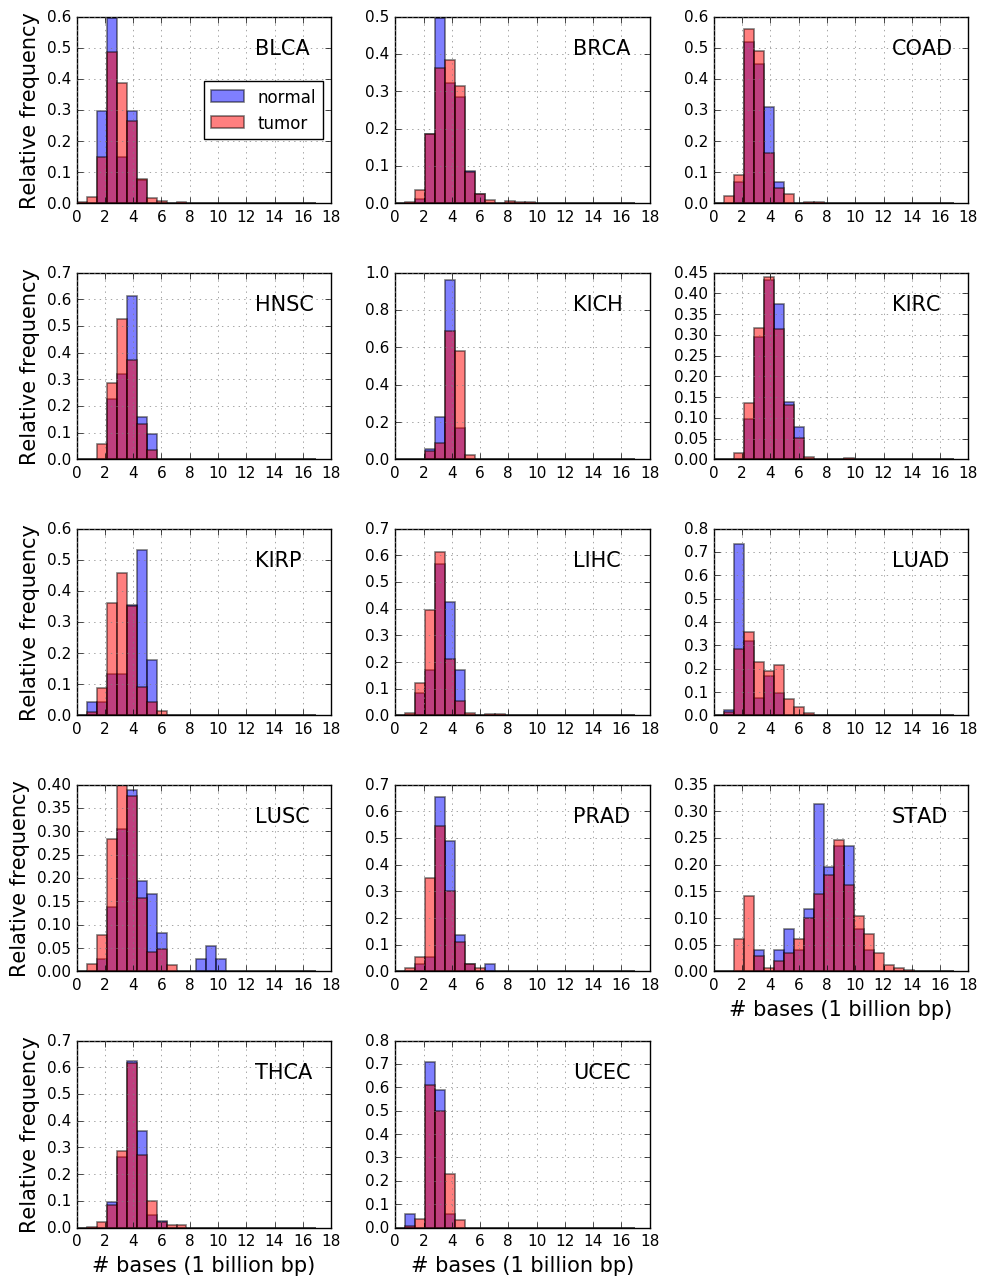

In [51]:
fig, axes = plt.subplots(5, 3, sharex=False, sharey=False, figsize=(10, 13))
axes = axes.ravel()

mi = odf.totalNumBases.min()
ma = odf.totalNumBases.max()
bins = np.linspace(0, ma, 25)
bins /= 1e9

for k, disease in enumerate(sorted(NT_DISEASES)):
    ax = axes[k]
    for sstype in ['normal', 'tumour']:
        color = 'blue' if sstype == 'normal' else 'red'
        _df = odf[(odf.disease == disease) & (odf.sstype == sstype)]
        ax.hist(_df.totalNumBases.values / 1e9, bins=bins, color=color, normed=True,
#                 histtype='step', 
                alpha=0.5,
                lw=1.2, label=sstype.replace('tumour', 'tumor'))
    ax.text(0.7, 0.8, disease, fontsize=15, transform=ax.transAxes)
    if k == 0:
        ax.legend(loc='center right')
#     if k % 3 == 0:
#         ax.set_ylabel('# samples', fontsize=15)
    if k + 1 >= 12:
        ax.set_xlabel('# bases (1 billion bp)', fontsize=15)
    if k % 3 == 0:
        ax.set_ylabel('Relative frequency', fontsize=15)

    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.grid(color='gray')
    
for i in range(14, 15):
    axes[i].patch.set_facecolor('white')
    axes[i].axis('off')    
plt.tight_layout()
# plt.savefig('./figs/verified-normal-tumour-samples-have-similar-sequencing-depth-normed.jpg', dpi=300)

In [ ]:
Scatter plot, another way to look at the data, but less informative

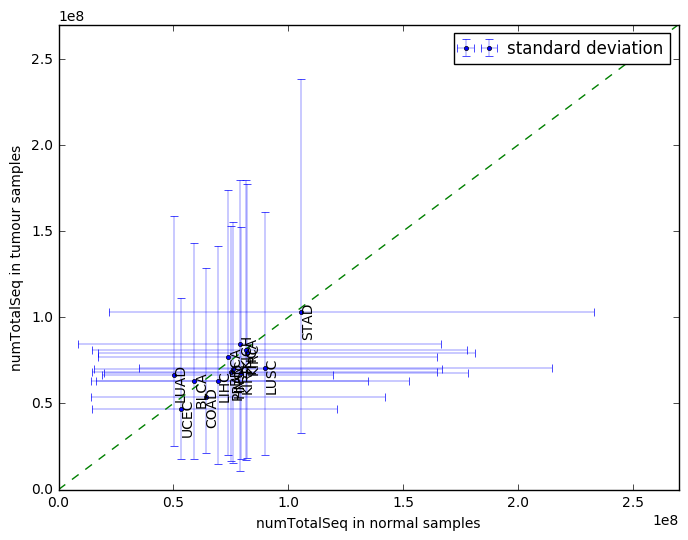

In [60]:
ms_df = grped.apply(
    lambda g: pd.Series([g.numTotalSeq.mean(), g.numTotalSeq.std()],
                        index=['mean', 'std']))\
    .reset_index()\
    .pivot(index='disease', columns='sstype')\
    .T[NT_DISEASES]

ms_df.applymap('{:,.3g}'.format)

mean = ms_df.loc['mean'].T
std = ms_df.loc['std'].T

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax = plt.axes()
ax.errorbar(mean['normal'].values, mean['tumour'].values,
            fmt='o',
            label='standard deviation',
            lw=0.3,
            markersize=3,
            xerr=[mean.normal.values - std.normal.values, mean.normal.values + std.normal.values],
            yerr=[mean.tumour.values - std.tumour.values, mean.tumour.values + std.tumour.values])
ax.set_xlabel('numTotalSeq in normal samples')
ax.set_ylabel('numTotalSeq in tumour samples')

xs = np.array([0, 3e8])
ax.plot(xs, xs, '--')

ax.legend()
ax.set_xlim(0, 2.7e8)
ax.set_ylim(0, 2.7e8)

for idx, row in mean.iterrows():
    ax.text(row.normal, row.tumour, idx, rotation=90)